In [1]:
%run include/utils.py
%matplotlib inline 

In [21]:
def plot_matrix(X, title='Title', xlabel='xlabel', ylabel='ylabel', figsize=None):
    if figsize is None:
        plt.figure(figsize=(25,6))
    else:
        plt.figure(figsize=figsize)
    plt.imshow(X, interpolation='none', vmax=np.max(X), vmin=0, aspect='auto')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


def draw_points(X, N1, xlim_, ylim_, title_='', W=None):
    plt.figure()
    plt.plot(X[:N1,0],X[:N1,1], 'b+')
    plt.plot(X[N1:,0],X[N1:,1], 'r*')
    plt.title(title_)
    plt.xlim(xlim_)
    plt.ylim(ylim_)
    
    if W is not None:
        x_ = np.arange(np.min(X),np.max(X),1e-2)
        y_ = (-x_*W[1]-W[0])/W[2]
        plt.plot(x_, y_, 'm-')
        
def gen_data_gauss(N1=50, N2=50, N3=50, draw=False,
                  center1 = np.array([2,8]),
                  center2 = np.array([5,5]),
                  center3 = np.array([8,2]),
                  var1 = np.array([1.2,1,1,1.2]).reshape((2,2)),
                  var2 = np.array([1.2,1,1,1.2]).reshape((2,2)),
                  var3 = np.array([1.0,1,1,1.0]).reshape((2,2))):
    # data stay in rows
    S1 = np.random.multivariate_normal(center1,var1,(N1))
    S2 = np.random.multivariate_normal(center2,var2,(N2))
    S3 = np.random.multivariate_normal(center3,var3,(N3))
    S1 = np.vstack((S1,S2))
    N1 = N1+N2
    # data matrix
    X = np.vstack((S1,S3))
    R = np.hstack((np.ones(len(S1)),-1*np.ones(len(S2))))
    if draw:
        draw_points(X, N1, [-2,12], [-2,12], title_="data points")
    return X, R, N1, N2

# Problem-1

### Notation
- Indices:
  - $n$ over samples
  - $m$ over data dimensions
  - $k$ over groups


- Samples: 
  - $(x_n, y_n)$ 
  - $n \in \{1,\ldots,N\}$
  - $x_n \in \mathcal{R}^M$
  - $y_n \in \{-1,1\}$
  - For notational conveince, set $x_n := [1, x_n^T]^T$. Now, $x_n \in \mathcal{R}^{M+1}$
  - Data stored in the **columns** of an $(M+1)\times N$ dimensional matrix $\mathbf{X}$ and class labels in $\mathbf{y} \in \mathcal{R}^N$.
  - So, $x_{m,n}$ is the value of the $m$'th dimension of the $n$ sample.
  
  
 - Weights:
  - First, define $K$ to be the number of groups, a fixed number.
  - Weights stored in the **rows** of an $K\times(M+1)$ dimensional matrix $\mathbf{W}$.
  - So, $w_{k,m}$ is the weight for the $m$'th dimension in $k$'th group.
  
  
 - Group probabilities (latent, not necassarily normalized):
  - The group probability of $x_n$ is stored in $n$'th the **row** of an $N \times K$ dimensional matrix $\mathbf{Z}$.
  - So, $z_{n,k}$ is the (unnormalized) probability of the $n$'th sample being in $k$'th group.
  
#### The risk for $n$'th sample:
\begin{align}
\hat{y}(x_n) &= \sum_{k=1}^K z_{n,k} \left( \sum_{m=0}^M w_{k,m}x_{m,n} \right) \\
&= \sum_{k=1}^K z_{n,k} \mathbf{X}[:,n] \mathbf{W}[k,:]
\end{align}

#### The overall risk:
\begin{align}
\text{risk}(\hat{y}; \mathbf{X}, \mathbf{y}) = -\sum_{n=1}^N y_n \hat{y}(x_n) 
\end{align}

#### Regularization:
\begin{align}
r_z &= \sum_{k=1}^K \sum_{n=1}^N z_{n,k} \log(z_{n,k}) \\
r_w &= \sum_{k=1}^K \sum_{m=1}^M w_{k,m}^2
\end{align}

### The objective function:
\begin{align}
f(\mathbf{W},\mathbf{Z}; \mathbf{X}, \mathbf{y}) = -\sum_{n=1}^N y_n \left( \sum_{k=1}^K z_{n,k} \left( \sum_{m=0}^M w_{k,m}x_{m,n} \right) \right) + \lambda \sum_{k=1}^K \sum_{n=1}^N z_{n,k} \log(z_{n,k}) + \mu \sum_{k=1}^K \sum_{m=1}^M w_{k,m}^2
\end{align}

### Partial derivatives
We now need partial derivatives for the optimization parameters: $w_{k,m}$ and $z_{n,k}$
\begin{align}
\frac{\partial f}{\partial w_{k,m}} &= -\sum_{n=1}^N y_n x_{m,n} z_{n,k} + 2\mu w_{k,m} \\
\frac{\partial f}{\partial z_{n,k}} &= -y_n \sum_{m=0}^M w_{k,m}x_{m,n} + \lambda(\log z_{n,k} +1)
\end{align}
Because the objective is minimization, we move in the negative direction of the gradient: $w_{k,m} := w_{k,m} - \frac{\partial f}{\partial w_{k,m}}$ and $z_{n,k} := z_{n,k}-\frac{\partial f}{\partial z_{n,k}}$

### The learning algorithm:
- Indices:
  - N: number of samples
  - M: dimensionality
  - K: number of groups 
- Initialize 
  - $\mathbf{W} \in K\times(M+1)$
  - $\mathbf{Z} \in N \times K$
- Set 
  - $x_n:= [1, x_n^T]^T$ for all $n\in \{1,\ldots,N\}$
  - learning rate $\eta=0.01$
  - regularizer for group parameters $\lambda=0.01$
  - regularizer for weights $\mu=0.01$
- Iterate until convergence
\begin{align}
w_{k,m} &:= w_{k,m} + \eta\left( \sum_{n=1}^N y_n x_{m,n} z_{n,k} - 2\mu w_{k,m}[m \neq 0] \right) \\
z_{n,k} &:= z_{n,k} + \eta\left( y_n \sum_{m=0}^M w_{k,m}x_{m,n} - \lambda(\log z_{n,k} +1) \right)
\end{align}

150
2
3
[[ 3.49811463 -2.42970602  0.67645479]
 [ 3.31250324 -2.79444032  0.64137663]
 [ 3.50195594 -2.69139727  0.36671047]]
[[ 6.03636119 -6.19954618  0.67645479]
 [ 5.88855029 -7.44693702  0.64137663]
 [ 5.98657797 -6.62855481  0.36671047]]
[[  8.21901492 -12.34788588   0.67645479]
 [         nan          nan   0.64137663]
 [         nan          nan   0.36671047]]
[[  8.21901492 -12.34788588   0.67645479]
 [         nan          nan   0.64137663]
 [         nan          nan   0.36671047]]


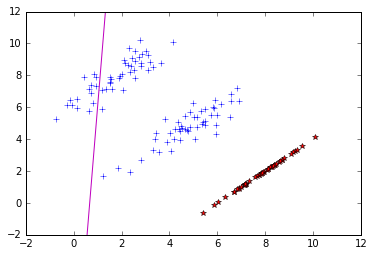

In [76]:
X, Y, N1, N2 = gen_data_gauss()
[N,M] = X.shape
K = 3
MAX_ITER = 3
eta = 0.01
lamb = 0.001
mu = 0.1
print(N)
print(M)
print(K)

X = np.hstack((np.ones(N1+N2).reshape((-1,1)),X)).transpose() # M+1 x N
W = np.random.random((K,M+1))
Z = np.random.random((N,K))*10

for s in range(MAX_ITER):
    for k in range(K):
        for m in range(M):
            tmp = 0
            for n in range(N):
                tmp += X[m,n]*Z[n,k]*Y[n]
            W[k,m] = W[k,m] + eta*(tmp-2*mu*W[k,m]*(m!=0))
    for k in range(K):
        for n in range(N):
            tmp = 0
            for m in range(M):
                tmp += W[k,m]*X[m,n]*Y[n]
            Z[n,k] = Z[n,k] + eta*(tmp-lamb*(np.log(Z[n,k])+1))
            Z[n,k] = Z[n,k]*(Z[n,k]<0) + Z[n,k]*(Z[n,k]>0)
    print(W)
            
print(W)

plt.figure()
plt.plot(X[1,:N1],X[2,:N1], 'b+')
plt.plot(X[1,N1:],X[2,N1:], 'r*')
plt.xlim([-2,12])
plt.ylim([-2,12])
for k in range(K):
    x_ = np.arange(np.min(X),np.max(X),1e-2)
    y_ = (-x_*W[k,1]-W[k,0])/W[k,2]
    plt.plot(x_, y_, 'm-')
        

# Problem-2

### Loading the data set

In [226]:
from sklearn.datasets import load_svmlight_file
from scipy import sparse
[X,y] = load_svmlight_file("data/A9A")
[L, N] = X.shape
print(str(L) + " samples, each " + str(N) + " dimensional.")

C = 20
L2_SVM = 1
if L1_SVM:
    U = C
else:
    U = 1e10
RESULT_FOLDER = "data/weights/"
MAX_ITER = 50

65123 samples, each 123 dimensional.


### Running the algorithm

In [227]:
alpha = np.zeros((1,L))
w0 = 0
w = np.zeros((1,N))

Qii = np.zeros(L)
for l in range(L):
    Qii[l] = (x_*x_.T)[0,0]

for it in range(MAX_ITER):
    now_ = time.time()
    for i in range(L):
        # step-1
        x_ = X[i,:].todense().reshape(N)
        G = (y[i]*x_*w.T - 1)[0,0] + (1-L1_SVM)/(2*C) 
        # step-2
        if alpha[0,i]==0:
            PG = np.min(G,0)
        elif alpha[0,i] == U:
            PG = np.max(G,0)
        elif 0<alpha[0,i] and alpha[0,i]<U:
            PG = G
        # step-3
        if np.abs(PG)!=0:
            alpha_old = alpha[0,i]
            # Qii = (x_*x_.T)[0,0]
            alpha[0,i] = min(max(alpha[0,i]-G/Qii[i],0),U)
            w = w + (alpha[0,i]-alpha_old)*y[i]*x_
            w0 = w0 + (alpha[0,i]-alpha_old)*y[i] 
    w_ = np.hstack((w,np.array(w0).reshape((1,1))))
    np.savetxt(RESULT_FOLDER+"w"+str(it)+".txt",w_)
    print("iteration: " + str(it) + ", duration: " + str(int(time.time()-now_)) + " seconds.")

iteration: 0, duration: 18 seconds.
iteration: 1, duration: 18 seconds.
iteration: 2, duration: 17 seconds.
iteration: 3, duration: 17 seconds.
iteration: 4, duration: 17 seconds.
iteration: 5, duration: 18 seconds.
iteration: 6, duration: 17 seconds.
iteration: 7, duration: 17 seconds.
iteration: 8, duration: 17 seconds.
iteration: 9, duration: 17 seconds.
iteration: 10, duration: 17 seconds.
iteration: 11, duration: 18 seconds.
iteration: 12, duration: 18 seconds.
iteration: 13, duration: 17 seconds.
iteration: 14, duration: 17 seconds.
iteration: 15, duration: 17 seconds.
iteration: 16, duration: 17 seconds.
iteration: 17, duration: 17 seconds.
iteration: 18, duration: 18 seconds.
iteration: 19, duration: 18 seconds.
iteration: 20, duration: 17 seconds.
iteration: 21, duration: 17 seconds.
iteration: 22, duration: 17 seconds.
iteration: 23, duration: 17 seconds.
iteration: 24, duration: 17 seconds.
iteration: 25, duration: 17 seconds.
iteration: 26, duration: 17 seconds.
iteration: 

### Plot the convergence

(0, 0.015982080681921418)

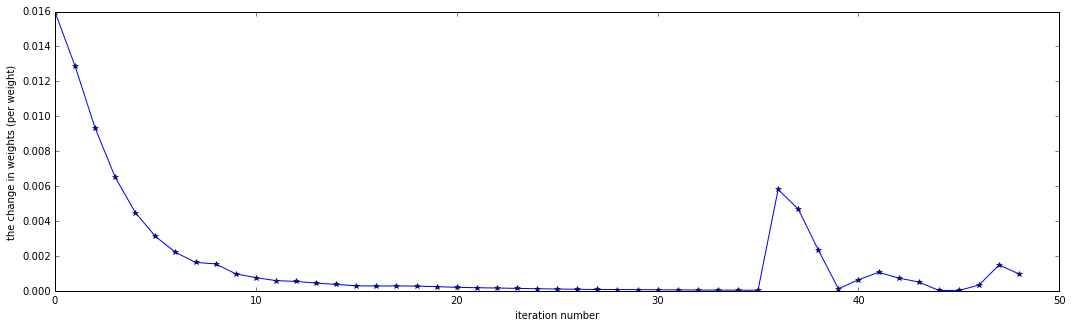

In [228]:
diff = []
w_old = np.loadtxt(RESULT_FOLDER+"w0.txt")
for i in range(1,MAX_ITER):
    w = np.loadtxt(RESULT_FOLDER+"w"+str(i)+".txt")
    diff_ = np.abs(np.sum(w-w_old))/len(w)
    diff.append(diff_)
    w_old = w

plt.figure(figsize=(18,5))
plt.plot(diff, '*-b')
plt.xlabel("iteration number")
plt.ylabel("the change in weights (per weight)")
plt.ylim([0,np.max(diff)])

### Print and plot accuracy

accuracy: 0.819667096616
accuracy: 0.82126405012
accuracy: 0.822185369449
accuracy: 0.822676739758
accuracy: 0.822738161047
accuracy: 0.822615318469
accuracy: 0.822369633315
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822492475892
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822431054604
accuracy: 0.822369633315
accuracy: 0.821448313986
accuracy: 0.821448313986
a

(0.81966709661568693, 0.82273816104661879)

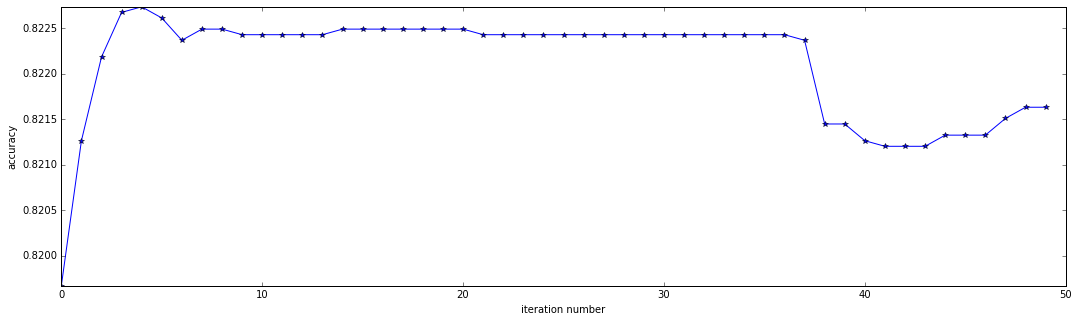

In [229]:
acc = []
for it in range(MAX_ITER):
    w_ = np.loadtxt(RESULT_FOLDER+"w"+str(it)+".txt")
    w0 = w_[-1]
    w = w_[:-2] # ignore the last weight and omit w0 appended at the end of w 

    # load the data set
    [Xt,yt] = load_svmlight_file("data/A9A.t")
    [Lt, Nt] = Xt.shape
    y_res = np.zeros(Lt)

    # compute my results
    for i in range(Lt):
        y_res[i] = (Xt[i]*w)[0]+w0

    acc_ = 1-np.sum(np.array(yt*y_res)<0)/len(y_res)
    acc.append(acc_)
    print("accuracy: " + str(acc_))

plt.figure(figsize=(18,5))
plt.plot(acc, '*-b')
plt.xlabel("iteration number")
plt.ylabel("accuracy")
plt.ylim([np.min(acc),np.max(acc)])

# Problem-3

 - Clustering the data to start with good initial $K$ and $\mathbf{Z}$ values.
 - k-fold cross validation for model parameters
 - linear regression but with basis functions
 - Do not compute gradient if $x_{n,m}$ is zero
 - What ensures the positivity of $z_{n,k}$?

In [169]:
%connect_info

{
  "shell_port": 42959,
  "hb_port": 45081,
  "control_port": 53971,
  "key": "b718bfcf-8583-400b-b3c6-f407a602d171",
  "signature_scheme": "hmac-sha256",
  "transport": "tcp",
  "stdin_port": 37598,
  "ip": "127.0.0.1",
  "iopub_port": 58084
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /run/user/1000/jupyter/kernel-051d73cd-0ee5-4057-947c-e6942cd20477.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.
